<a href="https://colab.research.google.com/github/tomasmta/Panama_COVID_SEIR/blob/main/COVID19_SEIR_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cleaning COVID data for Panama
* Source: [Johns Hopkins Covid Repository](https://github.com/CSSEGISandData/COVID-19)

Other resources:
* [Coding SEIR equations](https://www.youtube.com/watch?v=aU4jfY5E_ic)
* [ourworldindata.org](https://ourworldindata.org/coronavirus)
* [A Simulation of a COVID-19 Epidemic Based on a Deterministic SEIR Model](https://www.frontiersin.org/articles/10.3389/fpubh.2020.00230/full)

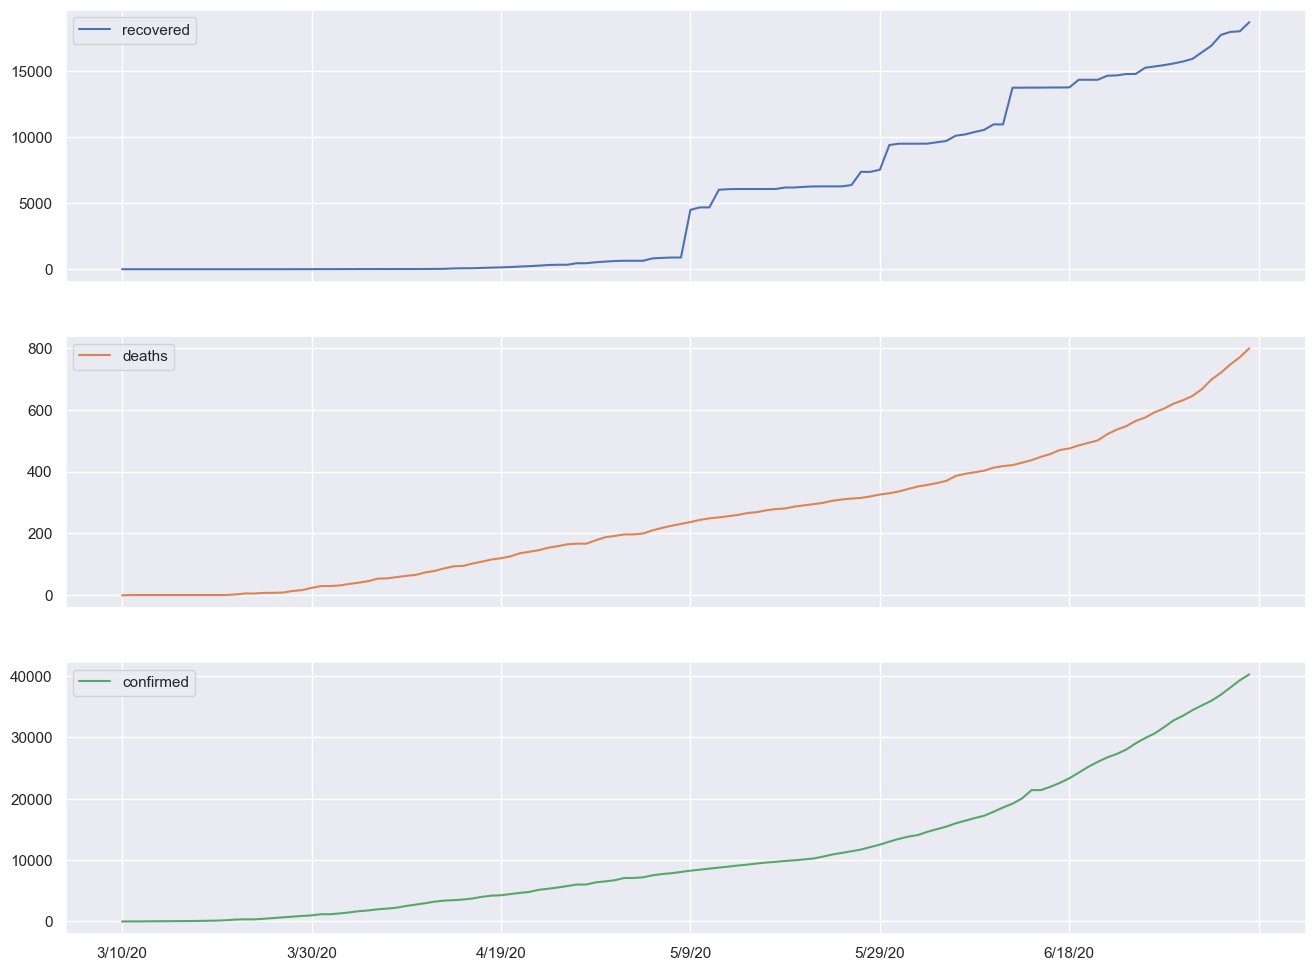

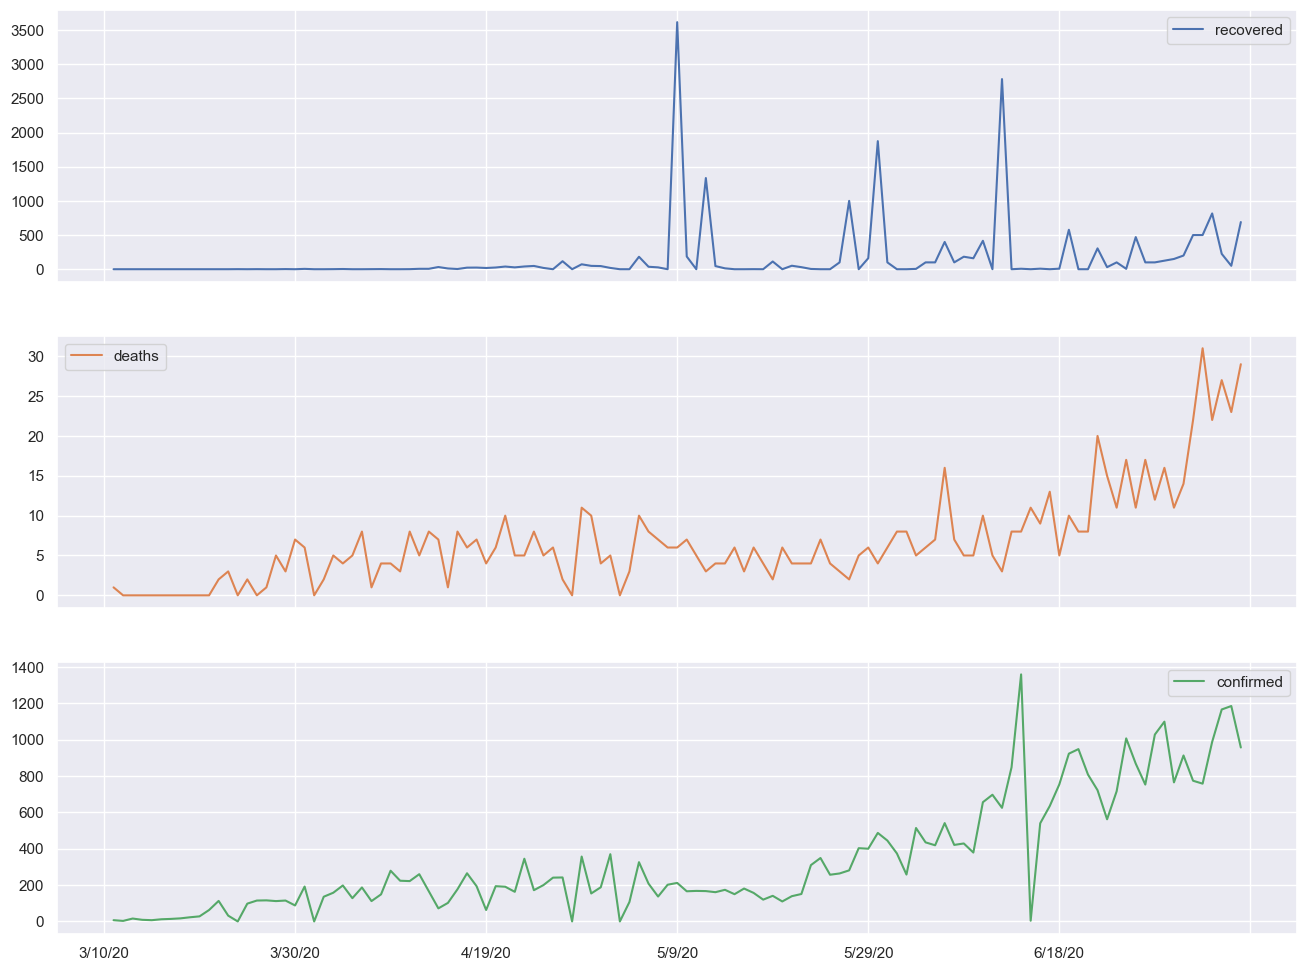

In [1]:
import pandas as pd 
import seaborn as sns

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(16, 4)})

# specify the number of days from data 
num_days = 120

# read csv
confirmed = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered = pd.read_csv('time_series_covid19_recovered_global.csv')

def clean(df,p):
    df = df.loc[df['Country/Region']=='Panama']
    df = df.drop(columns=['Country/Region', 'Lat', 'Long', 'Province/State'])
    df = df.transpose()
    df.rename(columns={df.columns[0]:p}, inplace=True)
    return df

re = clean(recovered, p ='recovered')
d = clean(deaths, p = 'deaths')
i = clean(confirmed, p = 'confirmed')
pty = pd.concat([re,d,i], axis=1)
pty = pty.loc[~(pty==0).all(axis=1)]
duration = num_days
pty = pty.iloc[0:duration] #511 #120
columns= pty.columns
pty[columns].plot(figsize=(16, 12), subplots=True)

daily = pd.DataFrame(pty.diff())
daily_columns = daily.columns

daily[daily_columns].plot(figsize=(16, 12), subplots=True)

actual_deaths = pty.deaths
actual_deaths = actual_deaths.apply(lambda x: float(x))
actual_deaths = actual_deaths.values.tolist()

actual_recovered = pty.recovered
actual_recovered = actual_recovered.apply(lambda x: float(x))
actual_recovered = actual_recovered.values.tolist()

actual_infected = pty.confirmed
actual_infected = actual_infected.apply(lambda x: float(x))
actual_infected = actual_infected.values.tolist()

daily_deaths = daily.deaths
daily_deaths = daily_deaths.apply(lambda x: float(x))
daily_deaths = daily_deaths.values.tolist()

### Testing

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(rc={'figure.figsize':(16, 24)})
SIZE = 20
plt.rc('font', size=SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)    # legend fontsize
plt.rc('figure', titlesize=SIZE)

def SEIR(fatality, beta, E, incubation, infectious):
    N0 = 4e6 # population of Panama
    mort = 1/75 # death rate defined as inverse of avg life expectancy
    birth = mort*N0 # Assuming birth rate is equal to death rate
    end_time = len(pty) -1 
    dt = 1
    num_steps = int(end_time/dt)
    
    s = np.zeros(num_steps+1)
    e = np.zeros(num_steps+1)
    i = np.zeros(num_steps+1)
    r = np.zeros(num_steps+1)
    n = np.zeros(num_steps+1)
    d = np.zeros(num_steps+1)
    
    e[0]= E
    i[0]= 1
    r[0]= 0
    n[0]= N0
    s[0]= N0 -e[0]-i[0]-r[0]
    
    for step in range(num_steps):
        n[step+1]   = s[step]+e[step]+i[step]+r[step]
        s2e = beta* s[step]*i[step]/n[step]
        e2i = (1/incubation)*e[step]
        i2r = (1/infectious)*i[step]
        
        s[step+1] = s[step] + dt*(birth-mort*s[step]-s2e)
        e[step+1] = e[step] + dt*(s2e - e2i - mort*e[step])
        i[step+1] = i[step] + dt*(e2i- i2r - (mort + fatality)*i[step])  
        r[step+1] = r[step] + dt*i2r -dt*mort*r[step]
        if step==0: pass
        else: 
            d[step] = -1*(s[step]-s[step-1] + e[step]-e[step-1] + i[step]-i[step-1] + r[step]-r[step-1])                
    return d,s,e,i,r


def objective(x): 
    fatality,beta,exposed,incubation,infectious = x
    d,s,e,i,r = SEIR(fatality,beta,exposed,incubation,infectious)
    seir_deaths = np.cumsum(d)
    seir_infected = np.array(i)
    seir_recovered =  np.array(r)

    d =  np.sqrt((seir_deaths - np.array(actual_deaths))  **2)
    i =  np.sqrt((seir_infected-np.array(actual_infected))  **2)
    r =  np.sqrt((seir_recovered-np.array(actual_recovered))  **2)
    
    cost = np.sum(1.0*d+1.0*r+1.0*i) 
    return cost 

# Run optimization n times
def run_n_times(n):
    list_results = []
    list_parameters = []
    for i in range(n):
        r = spo.dual_annealing(objective, bounds)
        list_results.append(r.fun)
        list_parameters.append(r.x)
        best_result = min(list_results)
        best_parameters = list_parameters[list_results.index(best_result)]
    return best_result, best_parameters

### Fit using Scipy Dual Annealing

In [3]:
import scipy.optimize as spo
bounds = [(9e-6,0.1),  # fatality 
          (0.1,0.99),    # beta probability of infection 
          (1,4000), # inital exposed
          (3,9),        # incubation
          (3,30)         # infectious period
         ]
best_result, best_parameters = run_n_times(10)
print(f"Best Results:{np.round(best_result,3)}\nBest Parameters: {best_parameters}")

Best Results:354651.142
Best Parameters: [9.75122169e-04 1.15017100e-01 1.87744205e+03 8.99946614e+00
 3.00000000e+01]


### Checking results ###

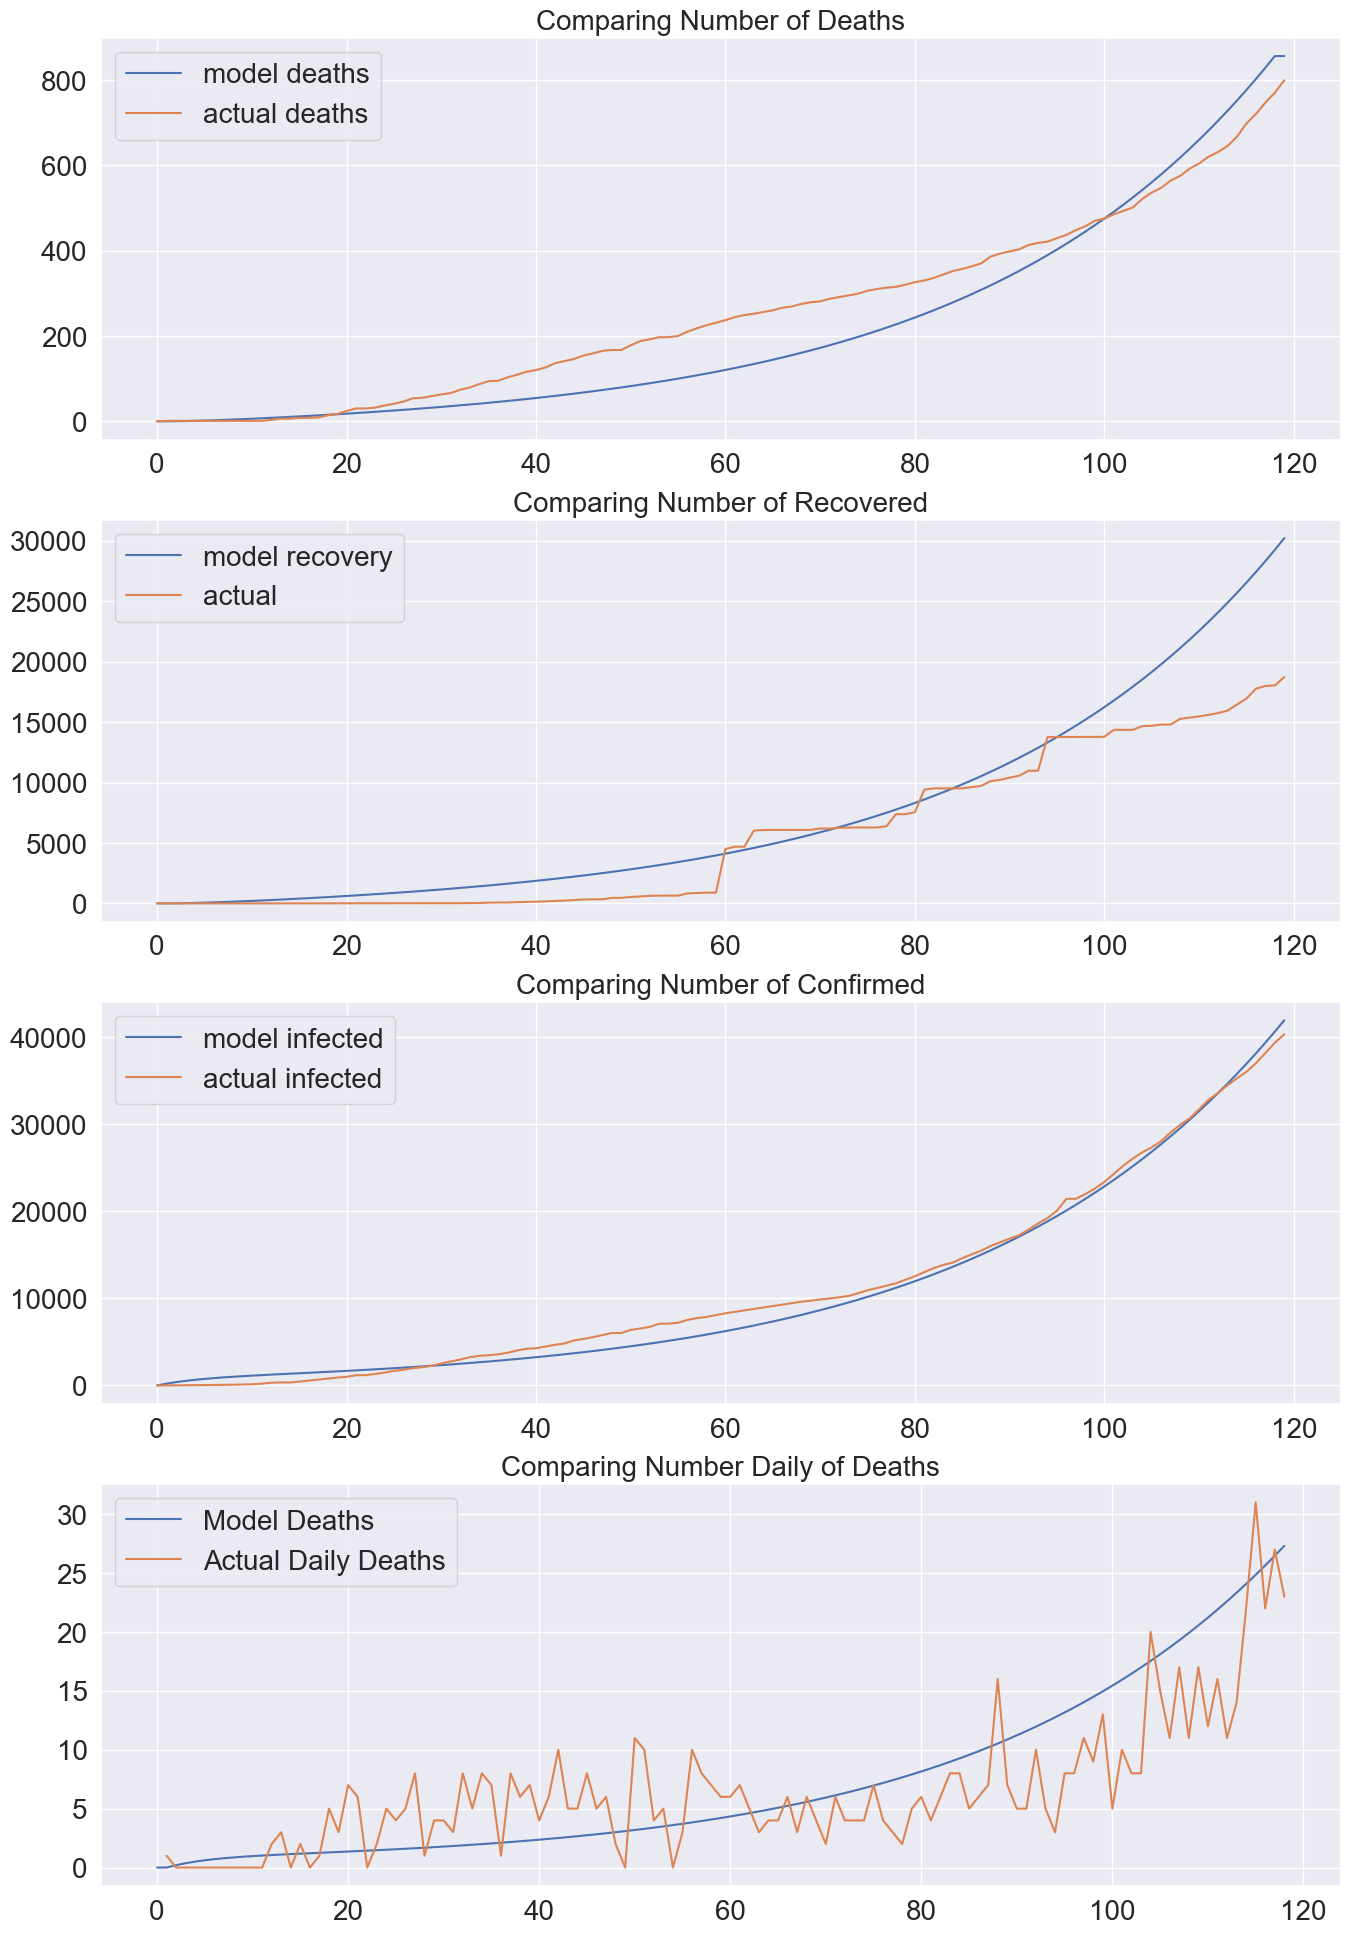

In [5]:
fatality, beta, E, incubation, infectious = best_parameters
d,s,e,i,r= SEIR(fatality, beta, E, incubation, infectious)

fig, ax = plt.subplots(4)
ax[0].plot(np.cumsum(d), label="model deaths")
ax[0].plot(actual_deaths, label= 'actual deaths')
ax[0].set_title('Comparing Number of Deaths')
ax[0].legend(loc="best")


ax[1].plot(r, label="model recovery")
ax[1].plot(actual_recovered, label= 'actual ')
ax[1].legend(loc="best")
ax[1].set_title('Comparing Number of Recovered')

ax[2].plot(i, label="model infected")
ax[2].plot(actual_infected, label= 'actual infected')
ax[2].legend(loc="best")
ax[2].set_title('Comparing Number of Confirmed')

ax[3].plot(d[0:-1], label="Model Deaths")
ax[3].plot(daily_deaths[0:-1], label= 'Actual Daily Deaths')
ax[3].legend(loc="best")
ax[3].set_title('Comparing Number Daily of Deaths')
plt.show()

### Calculating Reproduction Number

In [6]:
inv_incubation = 1/incubation
inv_recovery = 1/infectious
mort = 1/75
top = beta*inv_incubation
bottom = (inv_incubation+mort)*(inv_recovery+mort+fatality)
R0 = np.round(top/bottom,4)
print(f"Reproduction Number:{R0}")

Reproduction Number:2.1556


### Best combination of parameters

In [7]:
parameters = list(['Fatality','Transmission Prob(beta)','Init Exposed(E0)','Incubation','Recovery'])
for  i  in range(len(best_parameters)):
    print(f"{parameters[i]} = {np.round(best_parameters[i],4)}\n")

Fatality = 0.001

Transmission Prob(beta) = 0.115

Init Exposed(E0) = 1877.442

Incubation = 8.9995

Recovery = 30.0

